# 시나리오#1

### 웹 스크래핑, 크롤러
- 분단위 평균 기록횟수를 훌쩍 넘어가는 특정 시간대를 추출하여 리스팅
- 추출된 특정 시간대에서 사용된 UA 중 특수한 UA가 있는지 추출
- 추출된 특정 시간대에서 일반적인 접속량을 훌쩍 넘기는 Host 추출하여 리스팅
- 추출된 10개 Host의 패턴 분석 (Referer, Path, Bytes, 머무는 시간 등)
- 발견된 패턴대로 다른 Host에 대입하여 웹 스크래핑 입증

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', family='AppleGothic') # 한글폰트 불러오기
plt.rcParams['axes.unicode_minus'] = False # - 안깨지게 하기

In [2]:
df = pd.read_csv('../dataset/track1.csv') # 데이터 프레임 초기화
df.Timestamp = pd.to_datetime(df.Timestamp) 
df = df[df['Status'].astype(str).str.isnumeric()] # 이상치 제거
df['Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M') # 시계열 데이터를 1분 단위로 설정
df.head()

,Timestamp,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
0,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-includes/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
1,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-login/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
2,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-register/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6232.0
3,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6248.0
4,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-content/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6224.0


In [3]:
time_grp = df.groupby(['Timestamp'])
time_grp.count()

,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
Timestamp,,,,,,,,,
2020-08-24 10:00,9,9,9,9,9,9,9,9,9
2020-08-24 10:01,11,11,11,11,11,11,11,11,11
2020-08-24 10:02,28,28,28,28,28,28,28,28,28
2020-08-24 10:03,38,38,38,38,38,38,38,38,38
2020-08-24 10:04,31,31,31,31,31,31,31,31,31
...,...,...,...,...,...,...,...,...,...
2020-08-28 19:42,48,48,48,48,48,48,48,48,48
2020-08-28 19:43,49,49,49,49,49,48,49,49,49
2020-08-28 19:44,54,54,54,54,54,54,54,54,54


# 분당 개별 유니크 호스트 수와 분당 가장 기록을 많이 남긴 호스트

In [4]:
funcHostUnique = lambda x: len(x['Host'].unique())
funcHostUniqueFirstValue = lambda x: x['Host'].value_counts()[0]
hostUnique = time_grp.apply(funcHostUnique)
hostUniqueFirstValue = time_grp.apply(funcHostUniqueFirstValue)

In [5]:
hostUniqueByMinute = pd.concat([(time_grp['Host'].count().rename('Count')), 
                      hostUnique.rename('HostUnq'), hostUniqueFirstValue.rename('HostFirstValue')], axis=1)

In [6]:
hostUniqueByMinute['HostUnq'].describe()

count    3822.000000
mean       81.928048
std        77.702654
min         1.000000
25%        35.000000
50%        66.000000
75%        75.000000
max       295.000000
Name: HostUnq, dtype: float64

In [7]:
hostUniqueByMinute['HostFirstValue'].describe()

count    3822.000000
mean       47.258503
std       162.658980
min         1.000000
25%         3.000000
50%         4.000000
75%        44.000000
max      3437.000000
Name: HostFirstValue, dtype: float64

In [12]:
hostUniqueByMinute.index = pd.to_datetime(hostUniqueByMinute.index)
hostUniqueByMinute.index = hostUniqueByMinute.index.strftime('%Y-%m-%d %H:%M')
hostUniqueByMinute

,Count,HostUnq,HostFirstValue
Timestamp,,,
2020-08-24 10:00,9,1,9
2020-08-24 10:01,11,9,3
2020-08-24 10:02,28,20,7
2020-08-24 10:03,38,22,10
2020-08-24 10:04,31,25,3
...,...,...,...
2020-08-28 19:42,48,36,3
2020-08-28 19:43,48,38,3
2020-08-28 19:44,54,37,4


AttributeError: 'Text' object has no property 'freq'

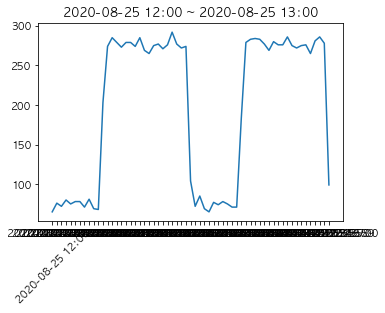

In [14]:
plt.figure(figsize=(12,8))
for i in range(4):
    x = hostUniqueByMinute[f'2020-08-25 {i+12}:00' : f'2020-08-25 {i+13}:00']['HostUnq'].index
    y = hostUniqueByMinute[f'2020-08-25 {i+12}:00' : f'2020-08-25 {i+13}:00']['HostUnq']
    plt.subplot(2, 2, i+1)
    plt.plot(x, y)
    plt.title(f'2020-08-25 {i+12}:00 ~ 2020-08-25 {i+13}:00')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

In [ ]:
hostUniqueByMinute.index = pd.to_datetime(hostUniqueByMinute.index)

# 개별 호스트 유니크 수가 많은 인위적인 시간 패턴이 존재한다.
- 하나의 호스트가 혼자 많은 접근을 시도하는 경우는 시간상을 찾을 수 없다.
- 여러개의 호스트가 평균보다 많은 접근을 시도하는 경우는 시계열 상에 인위적인 패턴으로 등장한다.

## 24일 패턴 없음

In [ ]:
labels = ['1분내 총 접근 기록', '1분내 접근한 총 호스트 수', '1분내 접근 기록 중 최다 접근 호스트의 접근 기록']
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-24 09:00':'2020-08-24 23:00']['HostFirstValue'].sort_index().plot()
plt.title('2020-08-24 패턴 없음')
plt.ylabel('count')
plt.ylim([0,3000])
plt.legend(labels)
plt.show()

## 25일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임

In [ ]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 18:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 18:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-25 09:00':'2020-08-25 18:00']['HostFirstValue'].sort_index().plot()
plt.title('2020-08-25')
plt.ylabel('count')
plt.ylim([0,3000])
plt.legend(labels)
plt.show()

## 26일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임

In [ ]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 18:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 18:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-26 09:00':'2020-08-26 18:00']['HostFirstValue'].sort_index().plot()
plt.title('2020-08-26')
plt.ylabel('count')
plt.ylim([0,3000])
plt.legend(labels)
plt.show()

## 27일 총 8번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임 (26일과 패턴이 똑같다)

In [ ]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 18:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 18:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-27 09:00':'2020-08-27 18:00']['HostFirstValue'].sort_index().plot()
plt.title('2020-08-27')
plt.ylabel('count')
plt.ylim([0,3000])
plt.legend(labels)
plt.show()

## 28일 총 6번 개별 호스트의 유니크 수가 급격히 늘어나는 패턴을 보임 (비슷한 패턴을 보인다)

In [ ]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['2020-08-28 12:00':'2020-08-28 17:00']['Count'].sort_index().plot()
hostUniqueByMinute['2020-08-28 12:00':'2020-08-28 17:00']['HostUnq'].sort_index().plot()
hostUniqueByMinute['2020-08-28 12:00':'2020-08-28 17:00']['HostFirstValue'].sort_index().plot()
plt.title('2020-08-28')
plt.ylabel('count')
plt.ylim([0,3000])
plt.legend(labels)
plt.show()

# 호스트가 단독으로 많이 들어오는 경우에는 시간에 따른 패턴이 없다.

In [ ]:
plt.figure(figsize=(9,6))
hostUniqueByMinute['HostFirstValue'].sort_index().plot()
plt.xticks(rotation=45)
plt.show()

In [ ]:
hostUniqueByMinute.index = hostUniqueByMinute.index.strftime('%Y-%m-%d %H:%M')

In [ ]:
anoPattern = hostUniqueByMinute[hostUniqueByMinute['HostUnq'] > 200].index

In [ ]:
# anoPattern = list(anomalyPattern)
anomalyPattern = anoPattern.tolist()
len(anomalyPattern)

In [ ]:
anoHost25 = df['2020-08-25']['Host'].value_counts()[2:52].index
anoHost25

In [ ]:
df.index = df.index.strftime('%Y-%m-%d %H:%M')
df.head()